In [1]:
%pip install -q diffusers
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import importlib
import train_conditioned_diffusion_model
importlib.reload(train_conditioned_diffusion_model)
from train_conditioned_diffusion_model import DiffusionModel
import dataset
importlib.reload(dataset)
from dataset import TinyImageNetDataset

device = "mps" if torch.backends.mps.is_available() else "cuda:4" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: you may need to restart the kernel to use updated packages.


2025-04-17 17:46:26.272441: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-17 17:46:26.577007: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-17 17:46:26.577053: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-17 17:46:26.578444: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-17 17:46:26.729804: I tensorflow/core/platform/cpu_feature_g

Using device: cuda:4


Loading text: 82115it [00:17, 4584.86it/s] 
Loading Images: 100%|██████████| 200/200 [00:00<00:00, 213342.01it/s]

500
Input shape: torch.Size([8, 3, 64, 64])
Word embeddings shape: torch.Size([8, 77, 768])
Labels: ('goldfish', ' Carassius auratus\n', ' Carassius auratus\n', 'goldfish', 'goldfish', ' Carassius auratus\n', 'goldfish', 'goldfish')


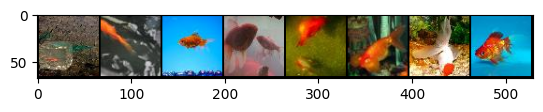

In [2]:
dataset = TinyImageNetDataset()
print(len(dataset))

# Feed it into a dataloader (batch size 8 here just for demo)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# View some examples
x, y, wnid, word = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Word embeddings shape:", y.shape)
print("Labels:", word)
plt.imshow(torchvision.utils.make_grid(x).permute(1, 2, 0))

In [25]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 64  # the generated image resolution
    train_batch_size = 64
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 150
    gradient_accumulation_steps = 1
    learning_rate = 1e-5
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-fish-64"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    # hub_model_id = "llqqmm/ddpm_fish"  # the name of the repository to create on the HF Hub
    hub_private_repo = None
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [4]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [5]:
model = DiffusionModel()
vae = model.vae
model = model.unet

Input shape: torch.Size([1, 3, 64, 64])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

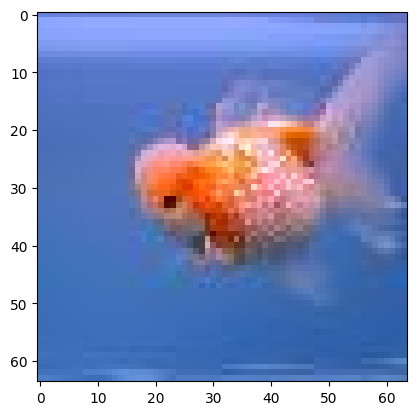

In [13]:
sample_image = dataset[0][0].unsqueeze(0)
plt.imshow(sample_image[0].permute(1,2,0))
print("Input shape:", sample_image.shape)

fish_tensor = dataset[0][1].unsqueeze(0)
init_image = sample_image * 2.0 - 1.0
init_image = init_image.to(dtype=torch.float32)
with torch.no_grad():
    img_latents = vae.encode(init_image).latent_dist.sample() # this constant scales vae output down to make it gaussian w std 1
    img_latents  = img_latents * 0.18215 
print(img_latents.shape, fish_tensor.shape)
print("Output shape:", model(img_latents, timestep=0, encoder_hidden_states = fish_tensor).sample.shape)


import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)
print(sample_image.max(), sample_image.min())

# im = Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])
im = Image.fromarray(((noisy_image.permute(0, 2, 3, 1))*255).type(torch.uint8).numpy()[0])
import numpy as np
im = np.array(im)
print(im.max())
plt.imshow(im)

In [ ]:
import torch.nn.functional as F

noise = torch.randn(img_latents.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(img_latents, noise, timesteps)


noise_pred = model(noisy_image, timestep = timesteps, encoder_hidden_states = fish_tensor).sample
loss = F.mse_loss(noise_pred, noise)

In [8]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [29]:
from torchvision.utils import make_grid
from PIL import Image
import torch
import os

def make_image_grid(images, rows=4, cols=4):
    grid = make_grid(images, nrow=cols)
    ndarr = (grid * 255).byte().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray(ndarr)

def evaluate(config, epoch, pipeline, vae):
    # Set eval mode just in case
    vae.eval()
    pipeline.unet.eval()

    batch_size = config.eval_batch_size
    device = pipeline.device

    # Dummy conditioning: [batch, 77, 768]
    # cond_tensor = fish_tensor.repeat(batch_size, 1, 1).to(device)
    cond_tensor = torch.ones(batch_size, 77, 768).to(device)


    # Create random latent noise in the shape expected by your VAE
    latents = torch.randn(
        (batch_size, 4, 8, 8),
        generator=torch.Generator(device=device).manual_seed(config.seed),
        device=device
    )

    with torch.no_grad():
        # Diffuse over timesteps
        for t in pipeline.scheduler.timesteps:
            latent_input = pipeline.scheduler.scale_model_input(latents, t)
            noise_pred = pipeline.unet(latent_input, t, encoder_hidden_states=cond_tensor).sample
            latents = pipeline.scheduler.step(noise_pred, t, latents).prev_sample

        # Scale back from latent space
        latents = latents / 0.18215
        images = vae.decode(latents).sample
        images = (images / 2 + 0.5).clamp(0, 1)  # Scale to [0,1] range

    # Save image grid
    img_grid = make_image_grid(images, rows=4, cols=4)
    sample_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(sample_dir, exist_ok=True)
    img_grid.save(os.path.join(sample_dir, f"{epoch:04d}.png"))


In [ ]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
from diffusers import StableDiffusionPipeline
from diffusers import DiffusionPipeline, DDPMPipeline



def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, vae):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    vae = vae.to(accelerator.device)
    vae.eval()  # optional but good if you're not training it



    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch[0]
            # Sample noise to add to the images
            init_image = clean_images * 2.0 - 1.0
            init_image = init_image.to(dtype=torch.float32)
            with torch.no_grad():
                img_latents = vae.encode(init_image).latent_dist.sample() # this constant scales vae output down to make it gaussian w std 1
                img_latents  = img_latents * 0.18215 

            noise = torch.randn(img_latents.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(img_latents, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                # cond_tensor = batch[1]
                cond_tensor = torch.ones(bs, 77, 768).to(clean_images.device)
                noise_pred = model(noisy_images, timesteps, encoder_hidden_states = cond_tensor, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            # from diffusers import DDIMScheduler

            # # Replace existing scheduler with DDIM (keep the same config if needed)
            # pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

            # # Optional: Customize steps and eta (controls stochasticity; 0 = deterministic)
            # pipeline.scheduler.set_timesteps(num_inference_steps=50)
            # pipeline.scheduler.eta = 0.0  # 0.0 = deterministic


            # pipeline = StableDiffusionPipeline(
            #     vae=vae,
            #     text_encoder=None,  # Optional if you aren't using text
            #     tokenizer=None,
            #     unet=accelerator.unwrap_model(model),
            #     scheduler=noise_scheduler,
            #     safety_checker=None,
            #     feature_extractor=None
            # )

            # pipeline = DiffusionPipeline(
            #     # vae=vae,
            #     unet=accelerator.unwrap_model(model),
            #     scheduler=noise_scheduler
            # )
            # pipeline.to(pipeline.unet.device)



            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline, vae)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

In [30]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, vae)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]